In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools as it
from MetricMethod import *
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [5]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [7]:
for coulumn in it.filterfalse(lambda x: x in 
                            set(['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']),
                            it.islice(df.columns, 0, None)):
    mean = df[coulumn].mean()
    std = df[coulumn].std()

    lower_limit = mean - 3 * std
    upper_limit = mean + 3 * std

    ind = (df[coulumn] < lower_limit) | (df[coulumn] > upper_limit)
    out = df[ind][[coulumn, 'diabetes']]
    if len(out) > 0:
        print(f'Нижняя граница {lower_limit}')
        print(f'Верхняя граница {upper_limit}')
        print(f'Количество {len(out)}')
        print(out)

Нижняя граница 7.410416850054897
Верхняя граница 47.23111734994511
Количество 1294
         bmi  diabetes
11     54.70         0
39     56.43         0
59     63.48         1
93     55.61         0
98     50.13         0
...      ...       ...
99770  59.45         0
99793  50.85         0
99844  59.42         0
99853  47.42         0
99953  60.52         0

[1294 rows x 2 columns]
Нижняя граница 2.3154907243493685
Верхняя граница 8.739523275650631
Количество 1315
       HbA1c_level  diabetes
40             9.0         1
55             9.0         1
59             8.8         1
135            9.0         1
169            9.0         1
...            ...       ...
99523          8.8         1
99663          9.0         1
99706          9.0         1
99740          9.0         1
99929          8.8         1

[1315 rows x 2 columns]
Нижняя граница 15.93365185388761
Верхняя граница 260.1824681461124
Количество 1403
       blood_glucose_level  diabetes
94                     300         1
10

In [8]:
for coulumn in it.filterfalse(lambda x: x in 
                            set(['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']),
                            it.islice(df.columns, 0, None)):
    mean = df[coulumn].mean()
    std = df[coulumn].std()

    lower_limit = mean - 3 * std
    upper_limit = mean + 3 * std

    ind = (df[coulumn] < lower_limit) | (df[coulumn] > upper_limit)
    ind_low = (df[coulumn] < lower_limit)
    ind_high = (df[coulumn] > upper_limit)
    out_low = df[ind_low][[coulumn, 'diabetes']]
    out_high = df[ind_high][[coulumn, 'diabetes']]
    out = df[ind][[coulumn, 'diabetes']]
    if len(out) > 0:
        print(out.groupby('diabetes')[coulumn].count())
    if len(out_low) > 0:
        print(out_low.groupby('diabetes')[coulumn].count())   
    if len(out_high) > 0:
        print(out_high.groupby('diabetes')[coulumn].count())
    print("____________________________")

____________________________
diabetes
0    928
1    366
Name: bmi, dtype: int64
diabetes
0    928
1    366
Name: bmi, dtype: int64
____________________________
diabetes
1    1315
Name: HbA1c_level, dtype: int64
diabetes
1    1315
Name: HbA1c_level, dtype: int64
____________________________
diabetes
1    1403
Name: blood_glucose_level, dtype: int64
diabetes
1    1403
Name: blood_glucose_level, dtype: int64
____________________________


In [9]:
df['gender'].value_counts()


Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'hypertension'}>,
        <AxesSubplot: title={'center': 'heart_disease'}>],
       [<AxesSubplot: title={'center': 'bmi'}>,
        <AxesSubplot: title={'center': 'HbA1c_level'}>,
        <AxesSubplot: title={'center': 'blood_glucose_level'}>],
       [<AxesSubplot: title={'center': 'diabetes'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

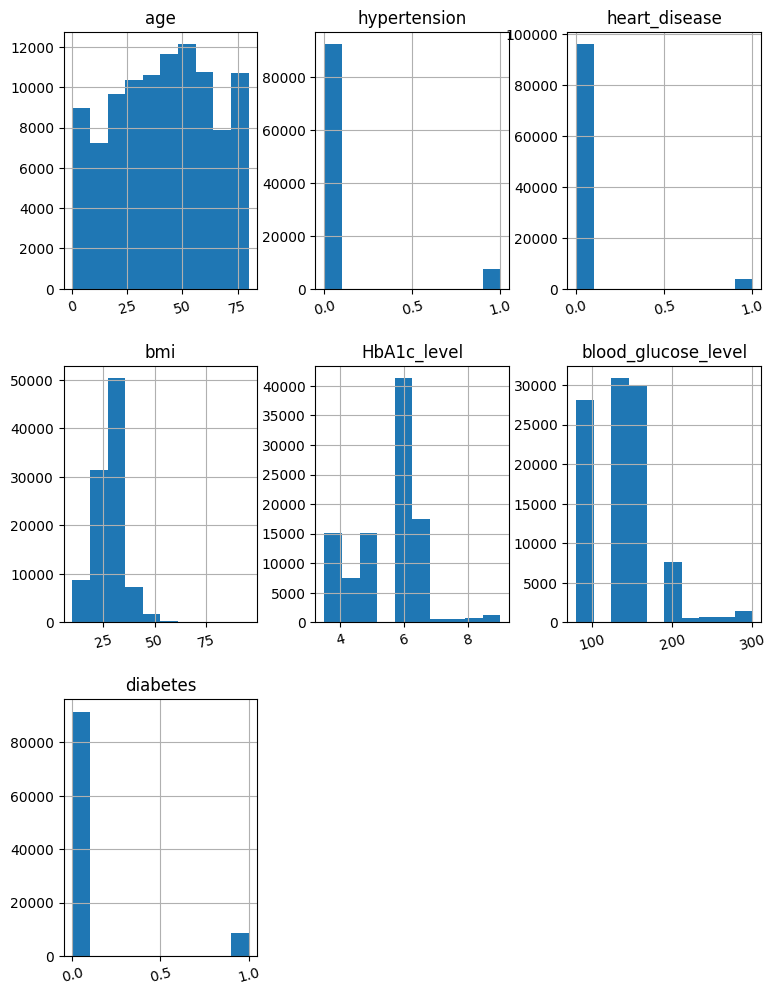

In [10]:

df.hist(figsize=(9, 12), xrot=15)

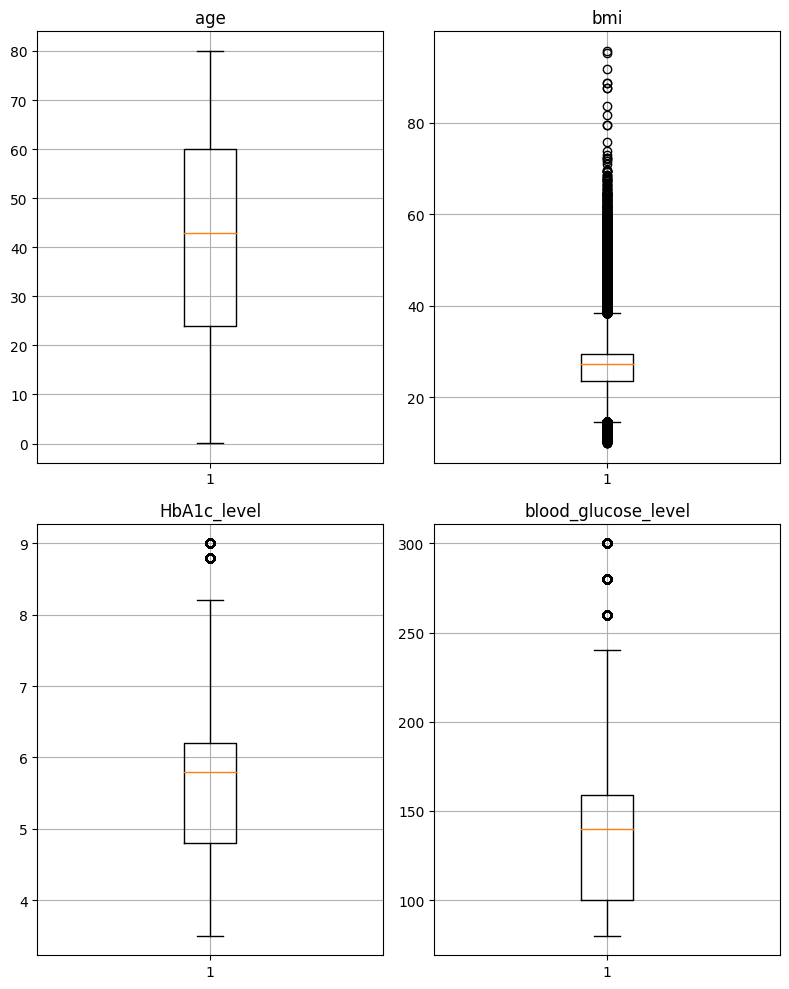

In [11]:
t = df.drop(columns=['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes'])

# Получение количества колонок
num_columns = len(t.columns)

# Расчет количества строк и столбцов для сетки
num_rows = int((num_columns + 1) / 2)  # Округляем вверх до ближайшего целого числа

# Создание сетки подграфиков
fig, axes = plt.subplots(num_rows, 2, figsize=(8, 10))

# Распаковка двумерного массива осей в одномерный массив
axes = axes.flatten()

# Построение ящиковых диаграмм для каждой колонки
for i, column in enumerate(t.columns):
    # Построение ящиковой диаграммы для текущей колонки
    axes[i].boxplot(t[column].astype(float))
    axes[i].grid(True)
    
    # Установка заголовка для текущего графика
    axes[i].set_title(column)

# Удаление пустых подграфиков
if num_columns % 2 != 0:
    fig.delaxes(axes[-1])

# Расположение подграфиков
fig.tight_layout()

# Отображение графиков
plt.show()

In [12]:
df.corr().round(4)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.0000,0.2512,0.2334,0.3374,0.1014,0.1107,0.2580
hypertension,0.2512,1.0000,0.1213,0.1477,0.0809,0.0844,0.1978
heart_disease,0.2334,0.1213,1.0000,0.0612,0.0676,0.0701,0.1717
bmi,0.3374,0.1477,0.0612,1.0000,0.0830,0.0913,0.2144
HbA1c_level,0.1014,0.0809,0.0676,0.0830,1.0000,0.1667,0.4007
blood_glucose_level,0.1107,0.0844,0.0701,0.0913,0.1667,1.0000,0.4196
diabetes,0.2580,0.1978,0.1717,0.2144,0.4007,0.4196,1.0000


In [13]:
phik_matrix(df).round(4)

interval columns not set, guessing: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
gender,1.0000,0.1204,0.0085,0.0469,0.1818,0.1209,0.0406,0.0221,0.0226
age,0.1204,1.0000,0.3383,0.3472,0.3685,0.6127,0.1425,0.1358,0.3541
hypertension,0.0085,0.3383,1.0000,0.1891,0.1826,0.1651,0.1383,0.1587,0.3056
heart_disease,0.0469,0.3472,0.1891,1.0000,0.1538,0.0787,0.1171,0.1453,0.2663
smoking_history,0.1818,0.3685,0.1826,0.1538,1.0000,0.2450,0.0827,0.0677,0.1942
bmi,0.1209,0.6127,0.1651,0.0787,0.2450,1.0000,0.1030,0.0975,0.2553
HbA1c_level,0.0406,0.1425,0.1383,0.1171,0.0827,0.1030,1.0000,0.3081,0.6660
blood_glucose_level,0.0221,0.1358,0.1587,0.1453,0.0677,0.0975,0.3081,1.0000,0.7952
diabetes,0.0226,0.3541,0.3056,0.2663,0.1942,0.2553,0.6660,0.7952,1.0000


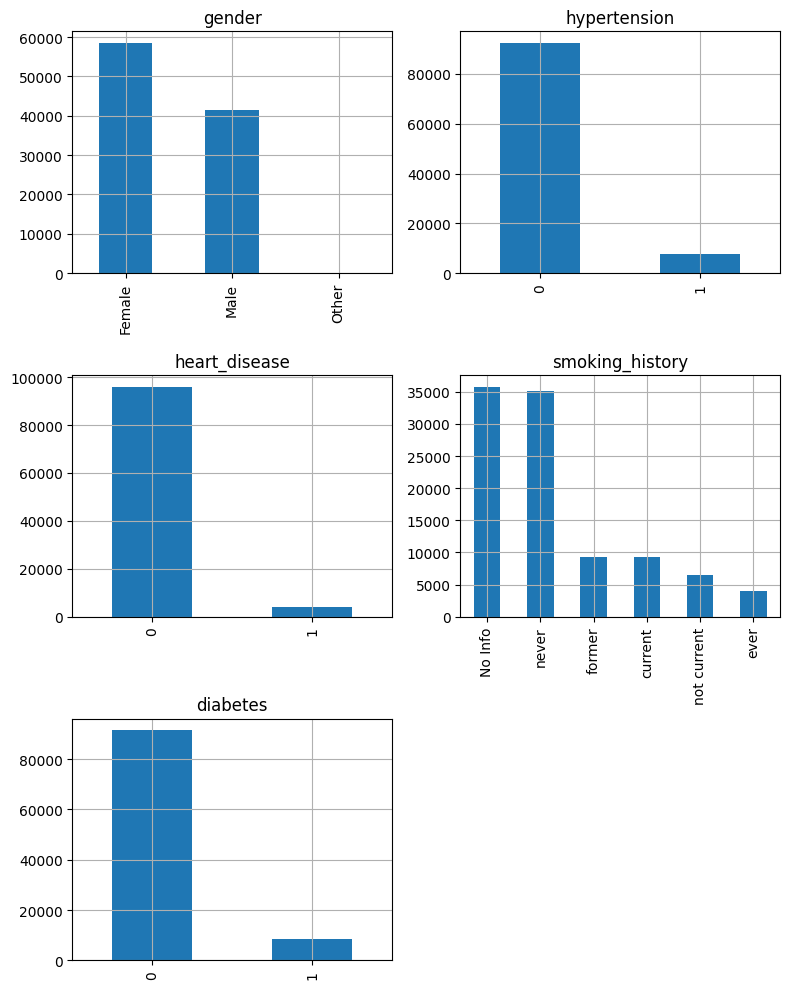

In [14]:
t = df[['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']]

# Получение количества колонок
num_columns = len(t.columns)

# Расчет количества строк и столбцов для сетки
num_rows = int((num_columns + 1) / 2)  # Округляем вверх до ближайшего целого числа

# Создание сетки подграфиков
fig, axes = plt.subplots(num_rows, 2, figsize=(8, 10))

# Распаковка двумерного массива осей в одномерный массив
axes = axes.flatten()

# Построение ящиковых диаграмм для каждой колонки
for i, column in enumerate(t.columns):
    # Построение ящиковой диаграммы для текущей колонки
    #axes[i].plot(t[column], kind='bar')
    t[column].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].grid(True)
    
    # Установка заголовка для текущего графика
    axes[i].set_title(column)

# Удаление пустых подграфиков
if num_columns % 2 != 0:
    fig.delaxes(axes[-1])

# Расположение подграфиков
fig.tight_layout()

# Отображение графиков
plt.show()

In [15]:
df_processed = pd.get_dummies(df, columns=['smoking_history', 'gender'], 
                              drop_first=True)
df_processed

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,gender_Male,gender_Other
0,80.0,0,1,25.19,6.6,140,0,0,0,0,1,0,0,0
1,54.0,0,0,27.32,6.6,80,0,0,0,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,0,0,0,1,0,1,0
3,36.0,0,0,23.45,5.0,155,0,1,0,0,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,6.2,90,0,0,0,0,0,0,0,0
99996,2.0,0,0,17.37,6.5,100,0,0,0,0,0,0,0,0
99997,66.0,0,0,27.83,5.7,155,0,0,0,1,0,0,1,0
99998,24.0,0,0,35.42,4.0,100,0,0,0,0,1,0,0,0


In [16]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

names = df_processed.columns
d = scaler.fit_transform(df_processed)

df_processed = pd.DataFrame(d, columns=names)
print(len(df_processed))
df_processed.head()

100000


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,gender_Male,gender_Other
0,1.000000,0.0,1.0,0.177171,0.563636,0.272727,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.674675,0.0,0.0,0.202031,0.563636,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.349349,0.0,0.0,0.202031,0.400000,0.354545,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.449449,0.0,0.0,0.156863,0.272727,0.340909,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.949950,1.0,1.0,0.118231,0.236364,0.340909,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
# Разделите датафрейм на тренировочный и остаточный набор данных
train_df, temp_df = train_test_split(df_processed, test_size=0.3, random_state=42)

train_X = train_df.drop(columns='diabetes')
train_y = train_df['diabetes']

# Разделите остаточный набор данных на валидационный и тестовый наборы данных
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

val_X = val_df.drop(columns='diabetes')
val_y = val_df['diabetes']

test_X = test_df.drop(columns='diabetes')
test_y = test_df['diabetes']

# Выведите размеры полученных наборов данных
print("Размер тренировочного набора данных:", train_df.shape)
print("Размер валидационного набора данных:", val_df.shape)
print("Размер тестового набора данных:", test_df.shape)

Размер тренировочного набора данных: (70000, 14)
Размер валидационного набора данных: (15000, 14)
Размер тестового набора данных: (15000, 14)


In [18]:
from imblearn.under_sampling import NearMiss

nm = NearMiss(version=1)
train_X_nm, train_y_nm = nm.fit_resample(train_X, train_y)
len(train_X_nm)

11906

In [19]:
from imblearn.under_sampling import NearMiss

nm = NearMiss(version=1)
train_X_nm, train_y_nm = nm.fit_resample(train_X, train_y)
len(train_X_nm)

11906

In [63]:
model = KNeighborsClassifier(n_neighbors=100)
model.fit(train_X_nm, train_y_nm)
pred_y = model.predict(test_X)

print(f'Accuracy {round(accuracy_score(test_y, pred_y), 4)}')
print(f'F1 {round(f1_score(test_y, pred_y), 4)}')
print(f'Precision {round(precision_score(test_y, pred_y), 4)}')
print(f'Recall {round(recall_score(test_y, pred_y), 4)}')

Accuracy 0.8454
F1 0.4403
Precision 0.3191
Recall 0.7097


In [47]:
model = KNN(countNeigbor=100, method='kdtree')
model.fit(train_X_nm, train_y_nm)
pred_y = model.predict(test_X)

print(f'Accuracy {round(accuracy_score(test_y, pred_y), 4)}')
print(f'F1 {round(f1_score(test_y, pred_y), 4)}')
print(f'Precision {round(precision_score(test_y, pred_y), 4)}')
print(f'Recall {round(recall_score(test_y, pred_y), 4)}')

Accuracy 0.8454
F1 0.4403
Precision 0.3191
Recall 0.7097


In [50]:
model = KNN_weight(countNeigbor=100, method='kdtree', weight_func= lambda x : 1/(x+0.00001))
model.fit(train_X_nm, train_y_nm)
pred_y = model.predict(test_X)

print(f'Accuracy {round(accuracy_score(test_y, pred_y), 4)}')
print(f'F1 {round(f1_score(test_y, pred_y), 4)}')
print(f'Precision {round(precision_score(test_y, pred_y), 4)}')
print(f'Recall {round(recall_score(test_y, pred_y), 4)}')

Accuracy 0.8357
F1 0.4304
Precision 0.3061
Recall 0.7245


In [57]:
model = ParzenWindowFixedWidth(width=0.15, method='kdtree')
model.fit(train_X_nm, train_y_nm)
pred_y = model.predict(test_X)

print(f'Accuracy {round(accuracy_score(test_y, pred_y), 4)}')
print(f'F1 {round(f1_score(test_y, pred_y), 4)}')
print(f'Precision {round(precision_score(test_y, pred_y), 4)}')
print(f'Recall {round(recall_score(test_y, pred_y), 4)}')

Accuracy 0.8349
F1 0.4051
Precision 0.293
Recall 0.656


In [62]:
model = ParzenWindowVariableWidth(countNeighbor=100, method='kdtree')
model.fit(train_X_nm, train_y_nm)
pred_y = model.predict(test_X)

print(f'Accuracy {round(accuracy_score(test_y, pred_y), 4)}')
print(f'F1 {round(f1_score(test_y, pred_y), 4)}')
print(f'Precision {round(precision_score(test_y, pred_y), 4)}')
print(f'Recall {round(recall_score(test_y, pred_y), 4)}')

Accuracy 0.8436
F1 0.4374
Precision 0.3161
Recall 0.7097


In [66]:
pred_y = np.array([0 for _ in range(len(test_y))])
print(f'Accuracy {round(accuracy_score(test_y, pred_y), 4)}')

Accuracy 0.9143


In [26]:
model = PotentialFunction(width=0.01, eps=0.05, method='kdtree')
model.fit(train_X_nm.sample(n=1000), train_y_nm.sample(n=1000))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\odo20\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\odo20\AppData\Local\Temp\ipykernel_11164\1088197578.py", line 2, in <module>
    model.fit(train_X_nm.sample(n=1000), train_y_nm.sample(n=1000))
  File "b:\Метрические методы классификации\MetricMethod\MetricMethods.py", line 381, in fit
    break
  File "b:\Метрические методы классификации\MetricMethod\MetricMethods.py", line 397, in predict
  File "b:\Метрические методы классификации\MetricMethod\MethodsOfGetNeighbours.py", line 92, in get_neighbours
    nearest_neighbor_index, distance = self.__kdtree.query_radius(point.reshape(1, -1), r=width, return_distance=True)
  File "sklearn\neighbors\_binary_tree.pxi", line 1257, in sklearn.neighbors._kd_tree.BinaryTree.query_radius
  File "C:\Users\odo20\AppData\Roaming\Python\Python310\site-packages\sklearn\ut

In [ ]:
pred_y = model.predict(test_X)

print(f'Accuracy {round(accuracy_score(test_y, pred_y), 4)}')
print(f'F1 {round(f1_score(test_y, pred_y), 4)}')
print(f'Precision {round(precision_score(test_y, pred_y), 4)}')
print(f'Recall {round(recall_score(test_y, pred_y), 4)}')

Accuracy 0.9131
F1 0.0046
Precision 0.125
Recall 0.0023
